In [1]:
!pip install opencv-python --upgrade

     |████████████████████████████████| 60.3 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
!pip install split-folders

On my computer, tensorflow and keras only worked with these settings

In [ ]:
!pip install tensorflow-gpu==2.4.0

In [ ]:
!pip install tensorflow==2.4.0

In [ ]:
!pip install keras==2.4.0

Imports

In [60]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import splitfolders
import seaborn as sn
from sklearn.metrics import plot_confusion_matrix

from random import randint
from skimage.util import random_noise

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [7]:
from tensorflow import keras 
from glob import glob
from random import choice, sample
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [8]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()  #disable for tensorFlow V2
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Instructions for updating:
non-resource variables are not supported in the long term


Mount Google drive, split data into train/val/test

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Note: This is the folder of images I used, which includes images from Google and friends' Instagram accounts. I did not feel comfortable sharing my friends' images, so I only submitted a folder of images from Google. Please see 'submission_pose' below to run the split_folders code. I have also saved dataframes of the pose outputs later on in the script, based on the complete set of images.

In [ ]:
!unzip '/content/gdrive/MyDrive/CS271Project/all_pose.zip'

In [ ]:
splitfolders.ratio('/content/all_pose', output='/content/split_pose', seed=1337,  ratio=(0.8,0.10,0.10)) 

Copying files: 213 files [00:00, 357.78 files/s]


'submission_pose' here

In [ ]:
!unzip '/content/gdrive/MyDrive/CS271Project/submission_pose.zip'

In [ ]:
splitfolders.ratio('/content/submission_pose', output='/content/split_pose', seed=1337,  ratio=(0.8,0.10,0.10)) 

Setting up Openpose and Functions

In [ ]:
protoFile = "/content/gdrive/MyDrive/CS271Project/pose_deploy_linevec.txt"
weightsFile = "/content/gdrive/MyDrive/CS271Project/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [ ]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [ ]:
def read_img(path):
  img = cv2.imread(path)
  frameWidth = img.shape[1]
  frameHeight = img.shape[0]

  net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

  # Fix the input Height and get the width according to the Aspect Ratio
  inHeight = 368
  inWidth = int((inHeight/frameHeight)*frameWidth)

  #noise_img = random_noise(img, mode='s&p',amount=0.1)

  inpBlob = cv2.dnn.blobFromImage(img, 1.0 / 255, (inWidth, inHeight),
                        (0, 0, 0), swapRB=False, crop=False)

  net.setInput(inpBlob)
  output = net.forward()

  return output, frameWidth, frameHeight

In [ ]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output, frameWidth, frameHeight):
  valid_pairs = []
  invalid_pairs = []
  n_interp_samples = 10
  paf_score_th = 0.1
  conf_th = 0.7

  #new start
  detected_keypoints = []
  keypoints_list = np.zeros((0,3))
  keypoint_id = 0
  threshold = 0.1

  for part in range(nPoints):
      probMap = output[0,part,:,:]
      probMap = cv2.resize(probMap, (frameWidth, frameHeight))
      keypoints = getKeypoints(probMap, threshold)
      keypoints_with_id = []
      for i in range(len(keypoints)):
          keypoints_with_id.append(keypoints[i] + (keypoint_id,))
          keypoints_list = np.vstack([keypoints_list, keypoints[i]])
          keypoint_id += 1

      detected_keypoints.append(keypoints_with_id)
  #new end

  # loop for every POSE_PAIR
  for k in range(len(mapIdx)):
      # A->B constitute a limb
      pafA = output[0, mapIdx[k][0], :, :]
      pafB = output[0, mapIdx[k][1], :, :]
      pafA = cv2.resize(pafA, (frameWidth, frameHeight))
      pafB = cv2.resize(pafB, (frameWidth, frameHeight))

      # Find the keypoints for the first and second limb
      candA = detected_keypoints[POSE_PAIRS[k][0]]
      candB = detected_keypoints[POSE_PAIRS[k][1]]
      nA = len(candA)
      nB = len(candB)

      # If keypoints for the joint-pair is detected
      # check every joint in candA with every joint in candB 
      # Calculate the distance vector between the two joints
      # Find the PAF values at a set of interpolated points between the joints
      # Use the above formula to compute a score to mark the connection valid
      
      if( nA != 0 and nB != 0):
          valid_pair = np.zeros((0,3))
          for i in range(nA):
              max_j=-1
              maxScore = -1
              found = 0
              for j in range(nB):
                  # Find d_ij
                  d_ij = np.subtract(candB[j][:2], candA[i][:2])
                  norm = np.linalg.norm(d_ij)
                  if norm:
                      d_ij = d_ij / norm
                  else:
                      continue
                  # Find p(u)
                  interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                          np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                  # Find L(p(u))
                  paf_interp = []
                  for k in range(len(interp_coord)):
                      paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                          pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                  # Find E
                  paf_scores = np.dot(paf_interp, d_ij)
                  avg_paf_score = sum(paf_scores)/len(paf_scores)
                  
                  # Check if the connection is valid
                  # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                  if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                      if avg_paf_score > maxScore:
                          max_j = j
                          maxScore = avg_paf_score
                          found = 1
              # Append the connection to the list
              if found:            
                  valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

          # Append the detected connections to the global list
          valid_pairs.append(valid_pair)
      else: # If no keypoints are detected
          #print("No Connection : k = {}".format(k))
          invalid_pairs.append(k)
          valid_pairs.append([])
  #print(valid_pairs)
  return valid_pairs, invalid_pairs, keypoints_list

In [ ]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [ ]:
# This function uses all of the above to output PersonwiseKeypoints given an image path
def img_to_keypts(path):
  output, frameWidth, frameHeight = read_img(path)
  valid_pairs, invalid_pairs, keypoints_list = getValidPairs(output, frameWidth, frameHeight)
  
  return getPersonwiseKeypoints(valid_pairs, invalid_pairs, keypoints_list)

**Transforming the Images into Data**

In [ ]:
yes_train = [x for x in glob('/content/split_pose/train/YES/**.**')]
no_train = [x for x in glob('/content/split_pose/train/NO/**.**')]

yes_val = [x for x in glob('/content/split_pose/val/YES/**.**')]
no_val = [x for x in glob('/content/split_pose/val/NO/**.**')]

yes_test = [x for x in glob('/content/split_pose/test/YES/**.**')]
no_test = [x for x in glob('/content/split_pose/test/NO/**.**')]

These take a while to run, so I have saved the outputs as dataframes later on.

In [ ]:
keypt_ytrain = np.array([img_to_keypts(x) for x in yes_train])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
keypt_ntrain = np.array([img_to_keypts(x) for x in no_train])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
keypt_yval = np.array([img_to_keypts(x) for x in yes_val])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
keypt_nval = np.array([img_to_keypts(x) for x in no_val])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
keypt_ytest = np.array([img_to_keypts(x) for x in yes_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
keypt_ntest = np.array([img_to_keypts(x) for x in no_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


Zero-pad all arrays and reshape to one row per image

In [ ]:
zero_pad_list = [keypt_ytrain, keypt_ntrain, keypt_yval, keypt_nval, keypt_ytest, keypt_ntest]

# find the maximum number of people in an image

max_shape = 0

for i in range(len(zero_pad_list)):

  X_out = zero_pad_list[i]

  for j in range(len(X_out)):
    temp_shape = X_out[j].shape[0]
    if temp_shape > max_shape:
      max_shape = temp_shape

 # add rows of zeros until all same shape
for i in range(len(zero_pad_list)):

  X_out = zero_pad_list[i]

  for k in range(len(X_out)):
    if X_out[k].shape[0] < max_shape:
      for j in range(max_shape-X_out[k].shape[0]):
        X_out[k] = np.append(X_out[k], np.zeros(shape=((max_shape-X_out[k].shape[0]), X_out[k].shape[1])), axis=0)

In [ ]:
# initialize all the flattened arrays

X_ytrain = np.zeros(shape=(len(yes_train), (keypt_ytrain[0].shape[0]*keypt_ytrain[0].shape[1])))
X_ntrain = np.zeros(shape=(len(no_train), (keypt_ntrain[0].shape[0]*keypt_ntrain[0].shape[1])))
X_yval = np.zeros(shape=(len(yes_val), (keypt_yval[0].shape[0]*keypt_yval[0].shape[1])))
X_nval = np.zeros(shape=(len(no_val), (keypt_nval[0].shape[0]*keypt_nval[0].shape[1])))
X_ytest = np.zeros(shape=(len(yes_test), (keypt_ytest[0].shape[0]*keypt_ytest[0].shape[1])))
X_ntest = np.zeros(shape=(len(no_test), (keypt_ntest[0].shape[0]*keypt_ntest[0].shape[1])))

In [ ]:
# reshape to each image to one row of data

flatten_arrays = [X_ytrain, X_ntrain, X_yval, X_nval, X_ytest, X_ntest]

for i in range(len(flatten_arrays)):
  for j in range(0, zero_pad_list[i].shape[0]):
    flatten_arrays[i][j] = zero_pad_list[i][j].reshape((1, flatten_arrays[i].shape[1]))

Create dataframes for each dataset

In [ ]:
df_ytrain = pd.DataFrame(X_ytrain)
df_ntrain = pd.DataFrame(X_ntrain)
df_yval = pd.DataFrame(X_yval)
df_nval = pd.DataFrame(X_nval)
df_ytest = pd.DataFrame(X_ytest)
df_ntest = pd.DataFrame(X_ntest)

In [ ]:
# label 1 for images that depict a family, 0 for no

df_ytrain['label'] = 1
df_ntrain['label'] = 0
df_yval['label'] = 1
df_nval['label'] = 0
df_ytest['label'] = 1
df_ntest['label'] = 0

In [ ]:
# concatenate 'yes' and 'no' for train, val, test

df_train = pd.concat([df_ytrain, df_ntrain])
df_val = pd.concat([df_yval, df_nval])
df_test = pd.concat([df_ytest, df_ntest])

In [ ]:
# replace null values with zeros

df_train = df_train.fillna(0)
df_val = df_val.fillna(0)
df_test = df_test.fillna(0)

In [ ]:
# save dataframes

df_train.to_csv('pose_traindf.csv', index=False)
df_val.to_csv('pose_valdf.csv', index=False)
df_test.to_csv('pose_testdf.csv', index=False)

**Load the saved dataframes**

In [10]:
df_train = pd.DataFrame(pd.read_csv('/content/gdrive/MyDrive/CS271Project/pose_traindf.csv'))
df_val = pd.DataFrame(pd.read_csv('/content/gdrive/MyDrive/CS271Project/pose_valdf.csv'))
df_test = pd.DataFrame(pd.read_csv('/content/gdrive/MyDrive/CS271Project/pose_testdf.csv'))

In [11]:
# concatenate train and val for models that don't use validation data

df_trainval = pd.concat([df_train, df_val])

**RNN**

In [12]:
def gen(df_name, batch_size=16):

  while True:

    X_out = []
    labels = []

    for i in range(batch_size):
      random_row = randint(0,len(df_name.index)-1)

      X_out.append(df_name.drop(columns=['label']).iloc[random_row])
      labels.append(df_name.iloc[random_row]['label'])

    X_out = np.asarray(X_out, dtype=np.float32)
    labels = np.asarray(labels, dtype=np.float32)

    yield X_out, labels

In [20]:
# create the model
model = Sequential()
model.add(Embedding(128, 19, input_length=(len(df_trainval.columns)-1)))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 570, 19)           2432      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               75776     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                

In [21]:
file_path = "openpose_rnn.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=10, verbose=1)

early_stop = EarlyStopping(monitor='loss', patience=10)

callbacks_list = [checkpoint, reduce_on_plateau, early_stop]

In [22]:
history = model.fit(gen(df_train, batch_size=16), use_multiprocessing=True, 
          validation_data=gen(df_val, batch_size=16), epochs=25, verbose=2, 
          workers=4, callbacks=callbacks_list, steps_per_epoch=100, validation_steps=50)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_acc improved from -inf to 0.59375, saving model to openpose_rnn.h5
100/100 - 44s - loss: 0.6841 - acc: 0.6019 - val_loss: 0.6805 - val_acc: 0.5938
Epoch 2/25

Epoch 00002: val_acc did not improve from 0.59375
100/100 - 42s - loss: 0.6825 - acc: 0.5769 - val_loss: 0.6847 - val_acc: 0.5800
Epoch 3/25

Epoch 00003: val_acc did not improve from 0.59375
100/100 - 42s - loss: 0.6776 - acc: 0.5875 - val_loss: 0.6823 - val_acc: 0.5900
Epoch 4/25

Epoch 00004: val_acc did not improve from 0.59375
100/100 - 42s - loss: 0.6768 - acc: 0.5969 - val_loss: 0.6804 - val_acc: 0.5913
Epoch 5/25

Epoch 00005: val_acc improved from 0.59375 to 0.60625, saving model to openpose_rnn.h5
100/100 - 42s - loss: 0.6845 - acc: 0.5769 - val_loss: 0.6769 - val_acc: 0.6062
Epoch 6/25

Epoch 00006: val_acc did not improve from 0.60625
100/100 - 42s - loss: 0.6671 - acc: 0.6206 - val_loss: 0.6821 - val_acc: 0.5913
Epoch 7/25

Epoch 00007: val_acc improved from 0.60625 to 0.61000, saving model to openp

In [23]:
# Final evaluation of the model
scores = model.evaluate(df_test.drop(columns=['label']), df_test['label'])
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 58.33%


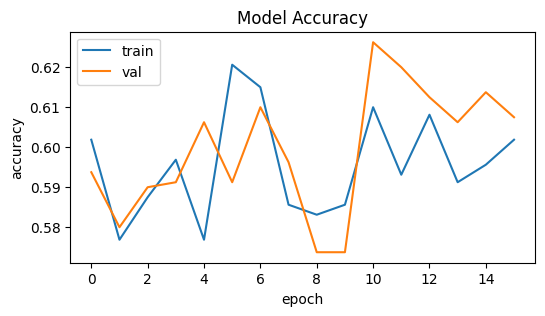

In [70]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.figure(figsize = (6,3))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

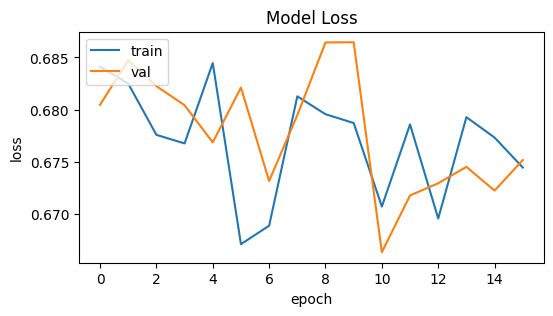

In [71]:
plt.figure(figsize = (6,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Ablation Study: KNN**

In [26]:
for i in range(1,7):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(df_trainval.drop(columns=['label']), df_trainval['label'])

  print('Accuracy of K-NN classifier on training set with ' + str(i) + ' neighbor(s): {:.2f}'
     .format(knn.score(df_trainval.drop(columns=['label']), df_trainval['label'])))
  
  print('Accuracy of K-NN classifier on test set with ' + str(i) + ' neighbor(s): {:.2f}'
     .format(knn.score(df_test.drop(columns=['label']), df_test['label'])))

Accuracy of K-NN classifier on training set with 1 neighbor(s): 1.00
Accuracy of K-NN classifier on test set with 1 neighbor(s): 0.50
Accuracy of K-NN classifier on training set with 2 neighbor(s): 0.84
Accuracy of K-NN classifier on test set with 2 neighbor(s): 0.50
Accuracy of K-NN classifier on training set with 3 neighbor(s): 0.83
Accuracy of K-NN classifier on test set with 3 neighbor(s): 0.46
Accuracy of K-NN classifier on training set with 4 neighbor(s): 0.79
Accuracy of K-NN classifier on test set with 4 neighbor(s): 0.42
Accuracy of K-NN classifier on training set with 5 neighbor(s): 0.77
Accuracy of K-NN classifier on test set with 5 neighbor(s): 0.42
Accuracy of K-NN classifier on training set with 6 neighbor(s): 0.76
Accuracy of K-NN classifier on test set with 6 neighbor(s): 0.42


In [27]:
# 2 neighbors was best

knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(df_trainval.drop(columns=['label']), df_trainval['label'])

# get predictions
predicted = knn2.predict(df_test.drop(columns=['label']))

Text(0.5, 1.0, 'KNN Test Results')

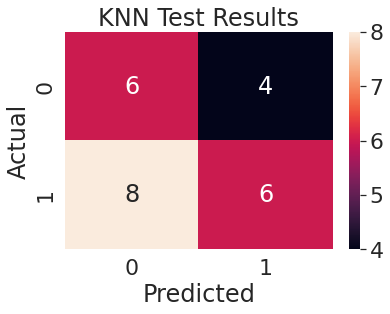

In [31]:
# confusion matrix for KNN test results

confusion_matrix = pd.crosstab(df_test['label'], predicted, rownames=['Actual'], colnames=['Predicted'])
sn.set(rc={'figure.figsize':(6,4)})
sn.set(font_scale=2)
sn.heatmap(confusion_matrix, annot=True).set_title("KNN Test Results")

**Ablation Study: SVM**

In [39]:
# linear kernel

svm1 = SVC(kernel='linear')
svm1.fit(df_trainval.drop(columns=['label']), df_trainval['label'])

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm1.score(df_trainval.drop(columns=['label']), df_trainval['label'])))

print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm1.score(df_test.drop(columns=['label']), df_test['label'])))

Accuracy of SVM classifier on training set: 0.99
Accuracy of SVM classifier on test set: 0.62


In [40]:
# poly kernel

svm2 = SVC(kernel='poly')
svm2.fit(df_trainval.drop(columns=['label']), df_trainval['label'])

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm2.score(df_trainval.drop(columns=['label']), df_trainval['label'])))

print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm2.score(df_test.drop(columns=['label']), df_test['label'])))

Accuracy of SVM classifier on training set: 0.68
Accuracy of SVM classifier on test set: 0.58


In [41]:
# sigmoid kernel

svm3 = SVC(kernel='sigmoid')
svm3.fit(df_trainval.drop(columns=['label']), df_trainval['label'])

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm3.score(df_trainval.drop(columns=['label']), df_trainval['label'])))

print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm3.score(df_test.drop(columns=['label']), df_test['label'])))

Accuracy of SVM classifier on training set: 0.61
Accuracy of SVM classifier on test set: 0.62


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


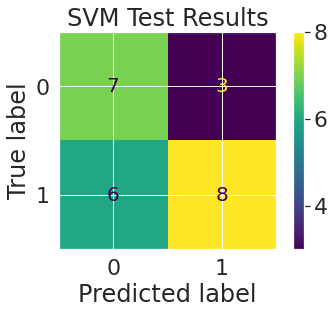

In [56]:
# linear kernel was best

matrix = plot_confusion_matrix(svm1, df_test.drop(columns=['label']), df_test['label'])
plt.title('SVM Test Results')
plt.rcParams.update({'font.size': 20})
plt.show(matrix)
plt.show()